# Forecastability

### Loading Libraries

In [1]:
%cd ../..

/Users/joaquinromero/Desktop


In [2]:
# Numerical Computing
import numpy as np

# Data Manipulation
import pandas as pd

# Data Visualization
import seaborn as sns
import plotly.io as pio
import plotly.express as px
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.figure_factory as ff

# Warnings
import warnings
import humanize

# IO & Requests
import time
import random
import requests
from io import StringIO

# StatsModels
import statsmodels.api as sm
from statsmodels.tsa.seasonal import MSTL , DecomposeResult

# OS
import os
import sys
import pickleshare
import missingno as msno
from itertools import cycle

# PyArrow
import pyarrow as pa

# FuncTools
from functools import partial

# Path & Notebook Optimizer
from pathlib import Path
import missingno as msno
from tqdm.auto import tqdm

# Scikit-Learn
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression, Ridge, Lasso

# IPython
from IPython.display import display, HTML

# NIXTLA
from statsforecast.core import StatsForecast
from utilsforecast.plotting import plot_series
from utilsforecast.evaluation import evaluate

# Custom Libraries
from src.utils import plotting_utils
# from src.utils.ts_utils import forecast_bias

# Forecast
# from datasetsforecast.losses import *
from utilsforecast.evaluation import evaluate
# from statsforecast.losses import mse, mae, mape, rmse, smape, mase

# Custom Libraries
from src.utils import plotting_utils

from src.utils.ts_utils_updated import (
    forecast_bias,
    forecast_bias_aggregate,
    metrics_adapter,
    smape,
    rmse,
    mae,
    mse,
    mase,
    average_length,
)

from statsforecast.models import (
    Naive,
    SeasonalNaive,
    HistoricAverage,
    WindowAverage,
    SeasonalWindowAverage,
    RandomWalkWithDrift,
    HoltWinters,
    AutoETS,
    AutoARIMA,
    ARIMA,
    AutoTheta,
    DynamicTheta,
    DynamicOptimizedTheta,
    Theta,
    OptimizedTheta,
    TBATS,
    AutoTBATS,
    MSTL
)

In [3]:
# from darts.models import Theta
# from darts.utils.utils import ModelMode, SeasonalityMode

In [4]:
!pip install statsforecast

In [5]:
tqdm.pandas()

np.random.seed(0)

pio.templates.default = "plotly_white"

sys.path.append('/Users/joaquinromero/Desktop/MTSF')

In [6]:
warnings.filterwarnings("ignore", category=UserWarning)

warnings.filterwarnings("ignore", category=FutureWarning)

warnings.filterwarnings("ignore", message="'force_all_finite' was renamed to 'ensure_all_finite'")

In [7]:
if 'NIXTLA_ID_AS_COL' in os.environ:
    del os.environ['NIXTLA_ID_AS_COL']
    
os.environ['NIXTLA_ID_AS_COL'] = '1'

In [8]:
os.makedirs("imgs/chapter_04", exist_ok=True)
preprocessed = Path.home() / "Desktop" / "data" / "london_smart_meters" / "preprocessed"

output = Path("data/london_smart_meters/output")

In [9]:
from itertools import cycle

def format_plot(fig, legends=None, xlabel="Time", ylabel="Value"):
    if legends:
        names = cycle(legends)
        fig.for_each_trace(lambda t: t.update(name=next(names)))

    fig.update_layout(
        autosize=False,
        width=900,
        height=500,
        title=dict(
            text=fig.layout.title.text if fig.layout.title.text else '',
            x=0.5,
            xanchor='center',
            yanchor='top',
            font=dict(size=20)
        ),
        legend_title=None,
        xaxis=dict(
            title=dict(
                text=xlabel,
                font=dict(size=12)
            )
        ),
        yaxis=dict(
            title=dict(
                text=ylabel,
                font=dict(size=12)
            )
        )
    )
    return fig

## Reading & Selecting Households

In [10]:
try:
    lclid_acorn_map = pd.read_pickle("data/london_smart_meters/preprocessed/london_smart_meters_lclid_acorn_map.pkl")
except FileNotFoundError:
    display(HTML("""
    <div class="alert alert-block alert-warning">
    <b>Warning!</b> File not found. Please make sure you have run 02 - Preprocessing London Smart Meter Dataset.ipynb in Chapter02
    </div>
    """))

In [11]:
affluent_households = lclid_acorn_map.loc[lclid_acorn_map.Acorn_grouped=="Affluent", ["LCLid",'file']]

adversity_households = lclid_acorn_map.loc[lclid_acorn_map.Acorn_grouped=="Adversity", ["LCLid",'file']]

comfortable_households = lclid_acorn_map.loc[lclid_acorn_map.Acorn_grouped=="Comfortable", ["LCLid",'file']]

In [12]:
size = 50

selected_households = pd.concat(
    [
        affluent_households.sample(size, random_state=76),
        comfortable_households.sample(size, random_state=76),
        adversity_households.sample(size, random_state=76),
    ]
)
selected_households['block']=selected_households.file.str.split("_", expand=True).iloc[:,1].astype(int)

In [13]:
# Extracting The Paths to The Different Blocks and Extracting The Starting and Ending Blocks
path_blocks = [
    (p, *list(map(int, p.name.split("_")[5].split(".")[0].split("-"))))
    for p in Path("data/london_smart_meters/preprocessed").glob(
        "london_smart_meters_merged_block*"
    )
]

In [14]:
household_df_l = []

for path, start_b, end_b in tqdm(path_blocks):
    block_df = pd.read_parquet(path)
    selected_households['block'].between
    mask = selected_households['block'].between(start_b, end_b)
    lclids = selected_households.loc[mask, "LCLid"]
    household_df_l.append(block_df.loc[block_df.LCLid.isin(lclids)])

  0%|          | 0/14 [00:00<?, ?it/s]

In [15]:
block_df = pd.concat(household_df_l)

del household_df_l
block_df.head()

,LCLid,start_timestamp,frequency,energy_consumption,series_length,stdorToU,Acorn,Acorn_grouped,file,holidays,...,windBearing,temperature,dewPoint,pressure,apparentTemperature,windSpeed,precipType,icon,humidity,summary
57,MAC000768,2012-04-21,30min,"[0.8440000000000001, 0.265, 0.262, 0.233999999...",32544,Std,ACORN-A,Affluent,block_1,"[NO_HOLIDAY, NO_HOLIDAY, NO_HOLIDAY, NO_HOLIDA...",...,"[251, 251, 251, 251, 246, 246, 242, 242, 244, ...","[6.42, 6.42, 6.2, 6.2, 5.68, 5.68, 5.16, 5.16,...","[3.54, 3.54, 3.61, 3.61, 3.52, 3.52, 3.11, 3.1...","[994.96, 994.96, 994.98, 994.98, 994.82, 994.8...","[3.79, 3.79, 3.67, 3.67, 3.15, 3.15, 2.61, 2.6...","[3.64, 3.64, 3.42, 3.42, 3.25, 3.25, 3.13, 3.1...","[rain, rain, rain, rain, rain, rain, rain, rai...","[partly-cloudy-night, partly-cloudy-night, par...","[0.82, 0.82, 0.83, 0.83, 0.86, 0.86, 0.87, 0.8...","[Partly Cloudy, Partly Cloudy, Partly Cloudy, ..."
63,MAC000948,2012-05-02,30min,"[0.008, 0.009, 0.008, 0.008, 0.008, 0.009, 0.0...",32016,Std,ACORN-A,Affluent,block_1,"[NO_HOLIDAY, NO_HOLIDAY, NO_HOLIDAY, NO_HOLIDA...",...,"[351, 351, 0, 0, 0, 0, 351, 351, 348, 348, 3, ...","[11.81, 11.81, 11.12, 11.12, 11.2, 11.2, 11.18...","[10.47, 10.47, 10.15, 10.15, 9.89, 9.89, 9.29,...","[1021.42, 1021.42, 1021.44, 1021.44, 1021.33, ...","[11.81, 11.81, 11.12, 11.12, 11.2, 11.2, 11.18...","[2.53, 2.53, 2.41, 2.41, 2.06, 2.06, 2.98, 2.9...","[rain, rain, rain, rain, rain, rain, rain, rai...","[partly-cloudy-night, partly-cloudy-night, par...","[0.91, 0.91, 0.94, 0.94, 0.92, 0.92, 0.88, 0.8...","[Mostly Cloudy, Mostly Cloudy, Mostly Cloudy, ..."
2827,MAC003299,2012-09-25,30min,"[0.254, 0.201, 0.183, 0.2189999999999999, 0.18...",25008,Std,ACORN-C,Affluent,block_5,"[NO_HOLIDAY, NO_HOLIDAY, NO_HOLIDAY, NO_HOLIDA...",...,"[220, 220, 218, 218, 215, 215, 211, 211, 207, ...","[10.93, 10.93, 10.81, 10.81, 10.27, 10.27, 10....","[7.76, 7.76, 8.07, 8.07, 8.04, 8.04, 7.62, 7.6...","[989.26, 989.26, 989.27, 989.27, 989.0, 989.0,...","[10.93, 10.93, 10.81, 10.81, 10.27, 10.27, 10....","[4.9, 4.9, 4.98, 4.98, 4.45, 4.45, 4.51, 4.51,...","[rain, rain, rain, rain, rain, rain, rain, rai...","[clear-night, clear-night, clear-night, clear-...","[0.81, 0.81, 0.83, 0.83, 0.86, 0.86, 0.84, 0.8...","[Clear, Clear, Clear, Clear, Clear, Clear, Cle..."
3389,MAC003157,2012-07-15,30min,"[0.181, 0.126, 0.13, 0.134, 0.18, 0.179, 0.118...",28464,ToU,ACORN-C,Affluent,block_6,"[NO_HOLIDAY, NO_HOLIDAY, NO_HOLIDAY, NO_HOLIDA...",...,"[250, 250, 259, 259, 267, 267, 284, 284, 286, ...","[12.72, 12.72, 12.72, 12.72, 12.98, 12.98, 12....","[12.01, 12.01, 12.0, 12.0, 12.32, 12.32, 11.83...","[1011.2, 1011.2, 1011.17, 1011.17, 1011.23, 10...","[12.72, 12.72, 12.72, 12.72, 12.98, 12.98, 12....","[1.73, 1.73, 2.15, 2.15, 2.31, 2.31, 2.28, 2.2...","[rain, rain, rain, rain, rain, rain, rain, rai...","[clear-night, clear-night, partly-cloudy-night...","[0.95, 0.95, 0.95, 0.95, 0.96, 0.96, 0.95, 0.9...","[Clear, Clear, Partly Cloudy, Partly Cloudy, P..."
3916,MAC000193,2012-01-01,30min,"[0.368, 0.386, 0.17, 0.021, 0.038, 0.038, 0.02...",37872,ToU,ACORN-D,Affluent,block_7,"[NO_HOLIDAY, NO_HOLIDAY, NO_HOLIDAY, NO_HOLIDA...",...,"[229, 229, 238, 238, 229, 229, 231, 231, 227, ...","[12.12, 12.12, 12.59, 12.59, 12.45, 12.45, 12....","[10.97, 10.97, 11.02, 11.02, 11.04, 11.04, 10....","[1008.1, 1008.1, 1007.88, 1007.88, 1007.95, 10...","[12.12, 12.12, 12.59, 12.59, 12.45, 12.45, 12....","[5.9, 5.9, 6.06, 6.06, 5.31, 5.31, 4.68, 4.68,...","[rain, rain, rain, rain, rain, rain, rain, rai...","[partly-cloudy-night, partly-cloudy-night, clo...","[0.93, 0.93, 0.9, 0.9, 0.91, 0.91, 0.93, 0.93,...","[Mostly Cloudy, Mostly Cloudy, Overcast, Overc..."


### Filling in Missing Values

In [16]:
from src.imputation.interpolation import SeasonalInterpolation

In [17]:
block_df.energy_consumption = block_df.energy_consumption.progress_apply(lambda x: SeasonalInterpolation(seasonal_period=48*7).fit_transform(x.reshape(-1,1)).squeeze())

  0%|          | 0/150 [00:00<?, ?it/s]

## Deseasonalizing and Detrending

In [18]:
from src.decomposition.seasonal import MultiSeasonalDecomposition

In [19]:
def make_stationary(row):
#     print(row)
    # Order of row: LCLid, timestamp, frequency, energy_consumption
    ts = row[3]
    dates = pd.date_range(start=row[1], freq=row[2], periods=len(ts))
    stl = MultiSeasonalDecomposition(seasonal_model="fourier",seasonality_periods=["day_of_year", "day_of_week", "hour"], model = "additive", n_fourier_terms=10)
    res = stl.fit(pd.Series(ts, index=dates))
    return res.resid.values# + res.trend.values

with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=DeprecationWarning) 
    block_df['residuals'] =[make_stationary(r) for r in tqdm(zip(*block_df.to_dict("list").values()), total=len(block_df))]

  0%|          | 0/150 [00:00<?, ?it/s]

## Forecastability Metrics

### Coefficient of Variation

In [20]:
from src.forecastability.cov import calc_cov

In [21]:
block_df["cov"] = block_df.progress_apply(lambda x: calc_cov(x['energy_consumption']), axis=1)

  0%|          | 0/150 [00:00<?, ?it/s]

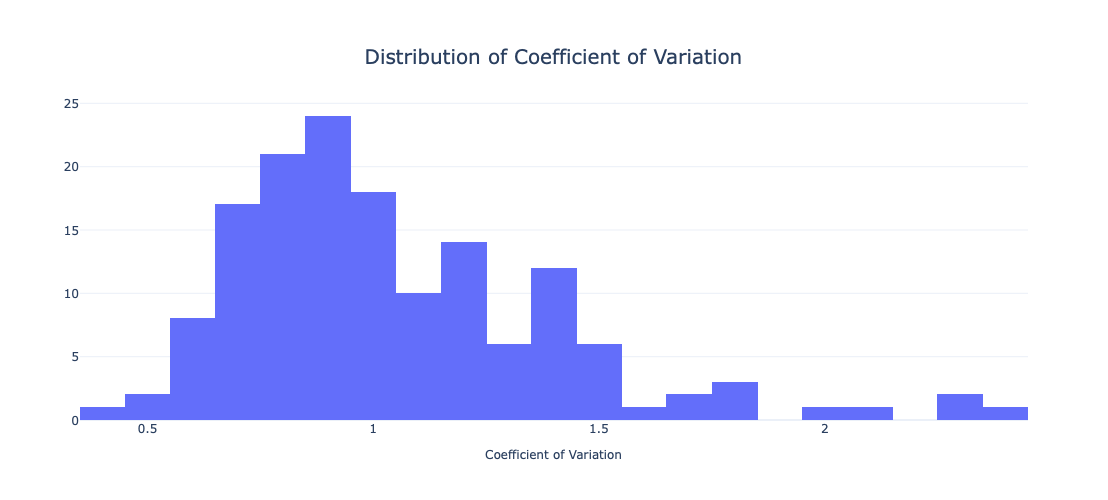

In [22]:
fig = px.histogram(x=block_df["cov"], title="Distribution of Coefficient of Variation")
fig = format_plot(fig, xlabel="Coefficient of Variation", ylabel="")
# fig.write_image("imgs/chapter_4/cov.png")
fig.show()

### Residual Variability

In [23]:
from src.forecastability.cov import calc_norm_sd

In [24]:
block_df["residual_variability"] = block_df.progress_apply(lambda x: calc_norm_sd(x['residuals'],x['energy_consumption']), axis=1)

  0%|          | 0/150 [00:00<?, ?it/s]

In [25]:
fig = px.histogram(x=block_df["residual_variability"], title="Distribution of Residual Variability")
fig = format_plot(fig, xlabel="Residual Variability", ylabel="")
# fig.write_image("imgs/chapter_4/rv.png")
fig.show()

### Spectral Entropy

In [30]:
# import sys
# sys.path.append('/Users/joaquinromero/Desktop/MTSF')

from src.forecastability.entropy import spectral_entropy

ModuleNotFoundError: No module named 'datasetsforecast'

In [39]:
%%time
block_df["residual_spectral_entropy"] = block_df.residuals.progress_apply(spectral_entropy)

NameError: name 'spectral_entropy' is not defined

In [ ]:
%%time
block_df["spectral_entropy"] = block_df.energy_consumption.progress_apply(lambda x: spectral_entropy(x, transform_stationary=True))

In [ ]:
fig = px.histogram(x=block_df["spectral_entropy"], title="Distribution of Spectral Entropy")
fig = format_plot(fig, xlabel="Spectral Entropy", ylabel="")
# fig.write_image("imgs/chapter_4/spectral_entropy.png")
fig.show()

In [ ]:
fig = px.histogram(x=block_df["residual_spectral_entropy"], title="Distribution of Residual Spectral Entropy")
fig = format_plot(fig, xlabel="Residual Spectral Entropy", ylabel="")
# fig.write_image("imgs/chapter_4/resid_spectral_entropy.png")
fig.show()

### Kaboudan Metric

In [ ]:
#cd ../../

In [ ]:
from src.forecastability.kaboudan import kaboudan_metric, modified_kaboudan_metric 

In [ ]:
%%time
block_size = 5
freq = '30min'
#models = [SeasonalNaive(season_length=48*7)]
#models = [SimpleExponentialSmoothing(alpha = 0.4, alias = 'SimpleExponentialSmoothing')]
models = [Theta(season_length=48*7, decomposition_type='additive')]


  
block_df["kaboudan_metric"] = [kaboudan_metric(r[0], 
                                               model=models[0], 
                                               block_size=block_size,  
                                               backtesting_start=0.5, 
                                               n_folds=1,
                                               freq = freq) 
                                               for r in tqdm(zip(*block_df[["energy_consumption"]].to_dict("list").values()), total=len(block_df))]

block_df[['LCLid','kaboudan_metric']].head()

In [ ]:
%%time
block_df["modified_kaboudan_metric"] = [modified_kaboudan_metric(r[0], 
                                               model=models[0], 
                                               block_size=block_size,  
                                               backtesting_start=0.5, 
                                               n_folds=1,
                                               freq = freq) 
                                               for r in tqdm(zip(*block_df[["energy_consumption"]].to_dict("list").values()), total=len(block_df))]

block_df[['LCLid','modified_kaboudan_metric']].head()

In [ ]:
fig = px.histogram(x=block_df["modified_kaboudan_metric"], title="Distribution of Modified Kaboudan Metric")
fig = format_plot(fig, xlabel="Modified Kaboudan Metric", ylabel="")
# fig.write_image("imgs/chapter_4/kaboudan_metric.png")
fig.show()

## Analysis

In [ ]:
forecastability_df = block_df[["LCLid",'spectral_entropy', 'residual_spectral_entropy',
       'modified_kaboudan_metric', 'cov', "kaboudan_metric",
       'residual_variability']]
rename_dict = {
    "spectral_entropy": "Spectral Entropy",
    "residual_spectral_entropy" : "Residual Spectral Entropy",
    "modified_kaboudan_metric": "Modified Kaboudan Metric",
    "kaboudan_metric": "Kaboudan Metric",
    "cov": "Coefficient of Variation",
    "residual_variability": "Residual Variability",
    
}
forecastability_df.to_pickle(output/"forecastability_metrics.pkl")

In [ ]:
def biplot(item_metrics_df, features, title="Loading Plot"):
    X = item_metrics_df[features].dropna()
    scaler = StandardScaler()
    scaler.fit(X)
    X=scaler.transform(X)
    pca = PCA(n_components=2, whiten=True)
    components = pca.fit_transform(X)
    loadings = pca.components_.T * np.sqrt(pca.explained_variance_)
    xs = components[:,0]
    ys = components[:,1]
    scalex = 1.0/(xs.max() - xs.min())
    scaley = 1.0/(ys.max() - ys.min())
    xl = loadings[:,0]
    yl = loadings[:,1]
    scalex_loading = 1.0/(xl.max() - xl.min())
    scaley_loading = 1.0/(yl.max() - yl.min())
    fig = px.scatter(x=xs * scalex, y=ys * scaley, opacity=0, template="plotly_white")
    for i, feature in enumerate(features):
        fig.add_shape(
            type='line',
            x0=0, y0=0,
            x1=xl[i]* scalex_loading,
            y1=yl[i]* scaley_loading,
            line=dict(color="indigo",
                width=2,
                dash="dot")
        )
        fig.add_annotation(
            x=xl[i]* scalex_loading,
            y=yl[i]* scaley_loading,
            ax=0, ay=0,
            xanchor="center",
            yanchor="bottom",
            text= feature, #"<b>"+feature+"</b>",
            font=dict(
            family="Open Sans, sans serif",
            size=16,
            color="MediumPurple"
            ),
        )
    fig.update_layout(title_text=title, title_x=0.5)
    
    fig.show()

### Rank Correlation of Forecastability Metrics

In [ ]:
def calc_rank(rank_df):
    for col in ['spectral_entropy', 'residual_spectral_entropy',
       'cov',"residual_variability"]:
        rank_df[col] = rank_df[col].rank(ascending=True)

    for col in ['modified_kaboudan_metric',"kaboudan_metric"]:
        rank_df[col] = rank_df[col].rank(ascending=False)

    return rank_df

item_rankings =calc_rank(forecastability_df.drop(columns="LCLid"))
item_rankings.rename(columns=rename_dict, inplace=True)
item_rankings.rename(index=rename_dict, inplace=True)

In [ ]:
corr_df = item_rankings.corr(method='spearman')
# corr_df.style.background_gradient(cmap='coolwarm')

In [ ]:
# mask = np.triu(np.ones_like(corr_df, dtype=bool))
# df_mask = corr_df.mask(mask).round(2)
df_mask = corr_df.round(2)

fig = ff.create_annotated_heatmap(z=df_mask.to_numpy(), 
                                  x=df_mask.columns.tolist(),
                                  y=df_mask.columns.tolist(),
                                  colorscale=px.colors.diverging.RdYlGn,
                                  hoverinfo="none", #Shows hoverinfo for null values
                                  showscale=True, ygap=1, xgap=1
                                 )

fig.update_xaxes(side="bottom")
# fig.update_traces(textfont_size=14)
fig.update_layout(
    title_text='Rank Correlation Plot - Forecastability Metrics', 
    title_x=0.5, 
    width=700, 
    height=700,
    xaxis_showgrid=False,
    yaxis_showgrid=False,
    xaxis_zeroline=False,
    yaxis_zeroline=False,
    yaxis_autorange='reversed',
    template='plotly_white'
)

# NaN values are not handled automatically and are displayed in the figure
# So we need to get rid of the text manually
for i in range(len(fig.layout.annotations)):
    fig.layout.annotations[i]['font']['size']=15
    if fig.layout.annotations[i].text == 'nan':
        fig.layout.annotations[i].text = ""

# fig.write_image("imgs/chapter_4/rank_correlation_forecastability.png")
fig.show()

### Rank Correlation of Forecastability vs Forecast Metrics

In [ ]:
base_metric_df = pd.read_pickle(output/"baseline_test_metrics_df.pkl")

In [ ]:
base_metric_df.head()

In [ ]:
forecastability_df = forecastability_df.merge(base_metric_df[base_metric_df.Algorithm=="AutoETS"], on="LCLid", how='inner')

In [ ]:
forecastability_df.head()

In [ ]:
def calc_rank(rank_df):
    for col in ['spectral_entropy', 'residual_spectral_entropy',
       'cov',"residual_variability"]:
        rank_df[col] = rank_df[col].rank(ascending=True)

    for col in ['modified_kaboudan_metric',"kaboudan_metric", "mae", "mse", "mase"]:
        rank_df[col] = rank_df[col].rank(ascending=False)
    
    # for col in ["Forecast Bias"]:
    #     rank_df[col] = np.abs(rank_df[col]).rank(ascending=False)

    return rank_df

item_rankings =calc_rank(forecastability_df.drop(columns=["LCLid",'Algorithm']))
item_rankings.rename(columns=rename_dict, inplace=True)
item_rankings.rename(index=rename_dict, inplace=True)
item_rankings.drop(columns=['Time Elapsed', "Model"], inplace=True)
corr_df = item_rankings.corr(method='spearman')

In [ ]:
corr_df.head()

In [ ]:
mask = np.zeros_like(corr_df).astype(bool)
mask[:5,:] = True
df_mask = corr_df.mask(mask).round(2)

fig = ff.create_annotated_heatmap(z=df_mask.to_numpy(), 
                                  x=df_mask.columns.tolist(),
                                  y=df_mask.columns.tolist(),
                                  colorscale=px.colors.diverging.RdYlGn,
                                  hoverinfo="none", #Shows hoverinfo for null values
                                  showscale=True, ygap=1, xgap=1
                                 )

fig.update_xaxes(side="bottom")
# fig.update_traces(textfont_size=14)
fig.update_layout(
    title_text='Rank Correlation Plot - Forecastability vs Forecast Metrics', 
    title_x=0.5, 
    width=700, 
    height=700,
    xaxis_showgrid=False,
    yaxis_showgrid=False,
    xaxis_zeroline=False,
    yaxis_zeroline=False,
    # yaxis_autorange='reversed',
    xaxis_range=[-0.5,5.5],
    yaxis_range=[5.5, 9.5]
)

# NaN values are not handled automatically and are displayed in the figure
# So we need to get rid of the text manually
for i in range(len(fig.layout.annotations)):
    fig.layout.annotations[i]['font']['size']=15
    fig.layout.annotations[i]['font']['color']="#000000"
    if fig.layout.annotations[i].text == 'nan':
        fig.layout.annotations[i].text = ""
# fig.write_image("imgs/chapter_4/rank_correlation_forecastability_vs_metrics.png")
fig.show()

In [ ]:
biplot(item_rankings, features=['Spectral Entropy',"Residual Spectral Entropy",
       'Modified Kaboudan Metric', 'Coefficient of Variation',"Kaboudan Metric",
       'Residual Variability', "mae", "mse", "mase"
       #,"Forecast Bias"
       ], title="<b>Loading Plot: Forecastability Metrics vs Error Metrics</b>")